# Test for bike trafic model

In [2]:
import sys
from pathlib import Path

# Trouve le dossier racine du projet (celui qui contient 'src')
project_root = Path().resolve().parents[0]  # si ton notebook est dans 'notebook/'
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

import pandas as pd
# import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from bike import indicators as ind
from bike import utils as ut
import matplotlib.cm as cm

from aequilibrae.paths import RouteChoice
from aequilibrae.matrix import AequilibraeMatrix

from utils_traffic import *


In [3]:
def simple_bi(graph, impact_coeff = 0.8):
    for u, v, d in graph.edges(data=True):
        if d['bikes']:
            d['length_bi']= d['length']*impact_coeff
        else:
            d['length_bi']= d['length']*(2-impact_coeff)
    return graph


def estimate_traffic (graph):
    for u,v,d in graph.edges(data=True):
        if d['type_car']=='primary':
            d['traffic']= 500
        elif d['type_car']=='secondary':
            d['traffic']=250
        else :
            d['traffic']=100

def pl_type_bike(type):
    if type == 'bike_lane' :
        return 0.9
    elif type == 'bike_path':
        return 0.7
    else :
        return 1.2

def pl_slope(slope):
    if abs(slope) > 0.6:
        return 1.1
    else:
        return 1
    
def pl_green(gb_coverage):
    if gb_coverage > 0.5:
        return 0.9
    else :
        return 1
    
def pl_traffic(traffic):
    if traffic > 251:
        return 1.3
    elif traffic < 100:
        return 1
    else :
        return 1.1
    

def simple_bi_2(graph):
    for u,v,d in graph.edges(data=True):
        perceived_l = 0
        perceived_l += pl_type_bike(d['type_bike'])
        perceived_l += pl_slope(d['slope'])
        perceived_l += pl_green(d['green_blue_coverage'])
        perceived_l += pl_traffic(d['traffic'])
        d['length_bi'] = perceived_l/4



def traffic_assigment(graph, origin, destination, demand, weight='length', print_path=False):
    for u, v, d in graph.edges(data=True):
        if 'flow' not in d:
            d['flow'] = 0
    #shortest path calculation based on 'weight' attribute
    path = nx.shortest_path(graph, source=origin, target=destination, weight=weight)
    #increment traffic on each edge in the path
    for i in range(len(path)-1):
        u = path[i]
        v = path[i+1]
        graph[u][v]['flow'] += demand
        #try :
        #    graph[u][v]['flow'] += demand
        #except KeyError:
        #    graph[u][v][key]['flow'] += demand
    if print_path:
        return path
    
def reset_flows(graph):
    for u, v, d in graph.edges(data=True):
        d['flow'] = 0

def plot_flow(G, title, pos=None):
    if pos is None:
        pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    # Récupérer les valeurs de flow pour normaliser les couleurs
    flows = [data.get('flow', 0) for u, v, data in G.edges(data=True)]
    max_flow = max(flows) if flows else 1

    # Créer une colormap basée sur le flow

    norm = plt.Normalize(vmin=0, vmax=max_flow)
    cmap = cm.Reds

    edge_colors_flow = [cmap(norm(data.get('flow', 0))) for u, v, data in G.edges(data=True)]

    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw(G, pos=pos, node_size=10, node_color='lightblue', 
        edge_color=edge_colors_flow, width=1.5, arrows=False, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['flow'] for u, v, d in G.edges(data=True)}, font_color='black')

    plt.title(title)
    plt.show()

def plot_graph(G):
    pos = {n: (d["x"], d["y"]) for n, d in G.nodes(data=True)}
    color_map = {'bike_lane': '#4E9F50FF', 'bike_path': '#EF8A0CFF'}
    edge_colors = []

    for _, _, edge in G.edges(data=True):
        # Détermination de la couleur en fonction de 'type_bike'
        bike_type = edge.get('type_bike')
        edge_colors.append(color_map.get(bike_type, "black"))

    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw(G, ax=ax, pos=pos, with_labels=True, node_size=300, font_size=8, edge_color=edge_colors, width=3, edgecolors="black", node_color="white")
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['length_bi'] for u, v, d in G.edges(data=True)}, font_color='black')
    plt.axis("equal")
    plt.show()

def reset_index(G):
    return nx.convert_node_labels_to_integers(G, label_attribute='old_id')

def code_to_int(code):
    letter = code[0]
    number = int(code[1])
    return (ord(letter) - ord('A')) * 2 + number

In [4]:
def generate_od_matrix(G, weight_0=0.4):    
    zones = G.nodes()
    valeurs = np.arange(0, 11)
    poids = [weight_0] + [(1 - weight_0)/10] * 10

    matrice = np.random.choice(valeurs, size=(len(zones), len(zones)), p=poids)
    np.fill_diagonal(matrice, 0)
    # Créer un DataFrame pour plus de lisibilité
    od_matrix = pd.DataFrame(matrice, index=zones, columns=zones)

    return od_matrix

In [4]:
G = nx.read_graphml("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/small_grid_graph.graphml")
G = reset_index(G)
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

In [5]:
print(ind.compute_all_indicators(G))
estimate_traffic(G)
simple_bi(G, impact_coeff=0.5)

{'Size': 24.0, 'Granularity': 1.0, 'Coverage': 0.5, 'Degree Centrality': 2.0000000000000004, 'Betweenness Centrality': 3.0, 'Number of Components': 1, 'Component Sizes': [0.5], 'Connectivity': 0.5555555555555555, 'Density 1': 0.041666666666666664, 'Global Efficiency': 0.5000000000000002, 'Local Efficiency': 0.0}


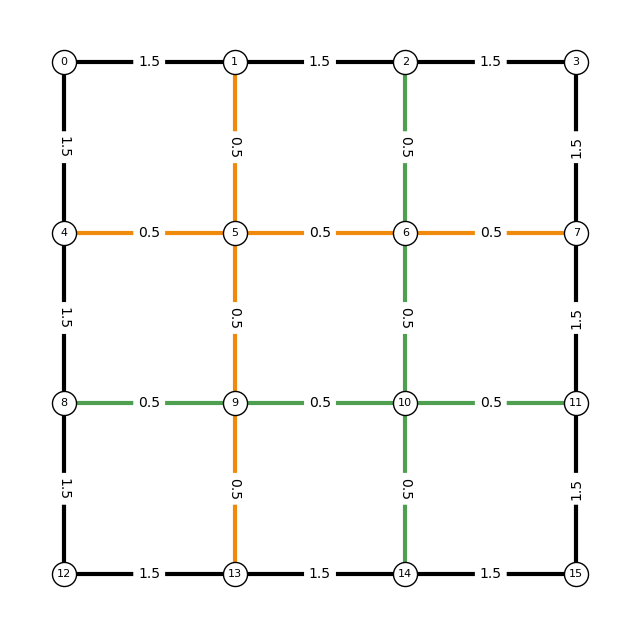

In [6]:
plot_graph(G)

In [9]:
od_matrix_big_city = generate_od_matrix(G, weight_0=0.9)

In [7]:
od_matrix_simple = pd.DataFrame(0, index=range(16), columns=range(16))
od_matrix_simple.loc[0,15] = 10
od_matrix_simple.loc[12,3] = 10

In [8]:
reset_flows(G)
for origin in od_matrix_simple.index:
    for destination in od_matrix_simple.columns:
            if od_matrix_simple.loc[origin, destination] > 0:
                demand = od_matrix_simple.loc[origin, destination]
                traffic_assigment(G, origin=origin, destination=destination, demand=demand, weight='length_bi')

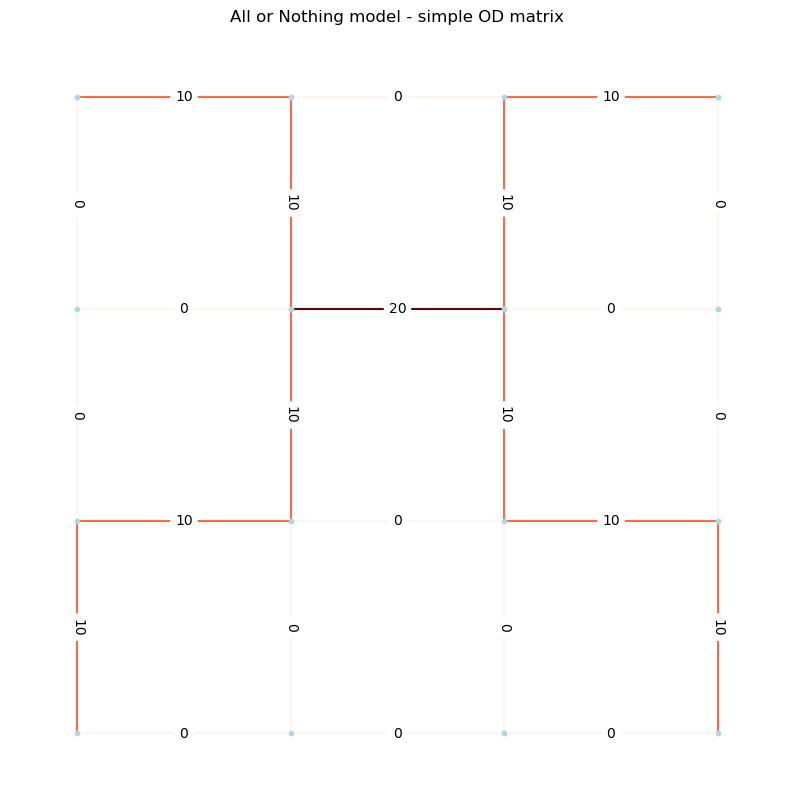

In [9]:
plot_flow(G, "All or Nothing model - simple OD matrix")

In [27]:
edges_df = nx.to_pandas_edgelist(G)

edges_df['travel_time']= 10.0
edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
edges_df.rename(columns={'target': 'b_node'}, inplace=True)
edges_df = edges_df[['a_node','b_node','length_bi','travel_time']]
edges_df.head()

,a_node,b_node,length_bi,travel_time
0,0,1,1.5,10.0
1,0,4,1.5,10.0
2,1,2,1.5,10.0
3,1,5,0.5,10.0
4,2,3,1.5,10.0


In [15]:
od_long = od_matrix_simple.stack().reset_index()
od_long.columns = ["origin", "destination", "demand"]
od_long["origin"]

od_long

,origin,destination,demand
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
251,15,11,0
252,15,12,0
253,15,13,0
254,15,14,0


In [28]:
results_stochastic = traffic_assignment_stochastic_aeq(
    network_df=edges_df,
    od_df=od_long,
    time_field='travel_time',
    cost_field='travel_time',
    algorithm='bfsle',
    max_routes=1
)

Starting stochastic assignment with bfsle algorithm...
Assignment completed successfully in 0.00 seconds.
Assignment Results:
Algorithm: bfsle
Max Routes: 1
Total Travel Time: 0.00

Total Travel Cost: 0.00



/opt/miniconda3/envs/env3/lib/python3.13/site-packages/aequilibrae/paths/route_choice.py:310: UserWarning: found unreachable OD pairs, no choice sets generated for: [(12, 3)]
  self.__rc.batched(


In [21]:
flows = results_stochastic['flow']
times = results_stochastic['time']
network_with_flows = results_stochastic['network']
route_choices = results_stochastic['route_choice_results']

In [18]:
# Convert nodes to a GeoDataFrame
nodes_data = [{'id': node, 'x':data['x'], 'y':data['y']} for node, data in G.nodes(data=True)]
nodes_gdf = gpd.GeoDataFrame(nodes_data)
#nodes_gdf['id_int'] = nodes_gdf['id'].apply(code_to_int)
nodes_gdf = nodes_gdf.set_index('id')

nodes_gdf.head()

,x,y
id,,
0,0,3
1,1,3
2,2,3
3,3,3
4,0,2


In [34]:
G_2 = nx.from_pandas_edgelist(
    network_with_flows,
    source='a_node',
    target='b_node',
    edge_attr=True)

In [ ]:
for u,v,d in G_2.edges(data=True):
    G_2[u][v]['x'] = d['flow']
    

(0, 1, {'speed': 80, 'traffic': 500, 'flow': 0.0, 'lanes': 4, 'type_car': 'primary', 'length': 1.0, 'length_bi': 1.5, 'type_bike': nan, 'bikes': False, 'travel_time': 0.1, 'travel_cost': 1.5})
(0, 4, {'speed': 80, 'traffic': 500, 'flow': 0.0, 'lanes': 4, 'type_car': 'primary', 'length': 1.0, 'length_bi': 1.5, 'type_bike': nan, 'bikes': False, 'travel_time': 0.1, 'travel_cost': 1.5})
(1, 2, {'speed': 80, 'traffic': 500, 'flow': 0.0, 'lanes': 4, 'type_car': 'primary', 'length': 1.0, 'length_bi': 1.5, 'type_bike': nan, 'bikes': False, 'travel_time': 0.1, 'travel_cost': 1.5})
(1, 5, {'speed': 50, 'traffic': 250, 'flow': 0.0, 'lanes': 2, 'type_car': 'secondary', 'length': 1.0, 'length_bi': 0.5, 'type_bike': 'bike_path', 'bikes': True, 'travel_time': 0.03333333333333333, 'travel_cost': 0.5})
(4, 5, {'speed': 50, 'traffic': 250, 'flow': 0.0, 'lanes': 2, 'type_car': 'secondary', 'length': 1.0, 'length_bi': 0.5, 'type_bike': 'bike_path', 'bikes': True, 'travel_time': 0.03333333333333333, 'trave

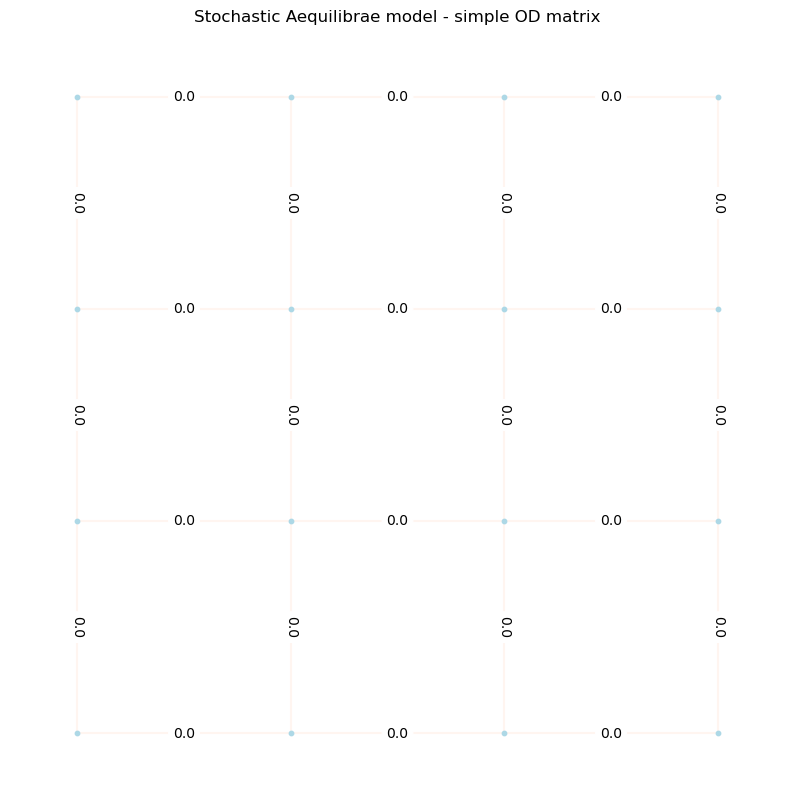

In [39]:
plot_flow(G_2, "Stochastic Aequilibrae model - simple OD matrix", pos=pos)